The goal of this notebook is to replicate the analysis of [Alsing, Silva, & Berti (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.478.1377A/abstract), up to minor differences in priors on parameters, etc, etc.  So far as we can tell, ASB have not released samples over their mass distribution inference, and we wanted them for a different project, so we re-implemented their analysis. 

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [22]:
import arviz as az
import astropy.io.ascii as aia
import h5py
import pandas as pd
import pystan
import re
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

colwidth = 433.62 / 72.0 # inches

pub_rc = {
    'figure.figsize': (colwidth, colwidth),
    'text.usetex': True
}

We believe there is an error in Eq. (4); the expression here should be identical to Eq. (3) with the replacement $m_T \to m_p \left( 1 + q \right)$, in other words, the integrand in the final line of Eq. (4) should read 
$$
\frac{\exp\left[ -\frac{\left( q - \hat{q} \right)^2}{2 \sigma_q^2} \right] \left( 1 + q \right)^{4/3}}{3 f^{1/3} m_p^{2/3} q^2 \sqrt{1 - \left(\frac{f}{m_p} \right)^{2/3} \frac{\left(1 + q\right)^{4/3}}{q^2}}}
$$

The `stan` program below implements the model of ASB.  We sample slightly differently than Alsing (in that we use MCMC to integrate over the mass ratio or total mass for the systems with these measurements, as well as sampling over the pulsar mass in each system).   
1. For the Gaussian $m_p$ measurements, we sample over $m_p$.
1. For the Gaussian $q$ measuremens, we sample over $q$ and $m_p$, according to the joint distribution defined in the (corrected) Eq. (4) of the ASB paper.
1. For the Gaussian $m_t$ measurements, we sample over $m_t$ and $m_p$, according to the joint distribution defined in Eq. (3) of the ASB paper.
We also employ several tricks so that the sampled-over variables satisfy the constraints of the problem ($q>0$, $m_p < m_t$, etc) and also so that the sampler sees densities as close to $N(0,1)$ as possible (so we end up transforming the well-constrained variables like $m_p$ for the Gaussian measurements, and $m_t$ and $q$).  If you look at the Stan program below, you will see that the `parameters` block contains `_raw` variables; these are as close as possible to $N(0,1)$ given the measurements and the need to always satisfy the bounded constraints in the problem.  `_raw` variables are transformed into physical variables in the `transformed parameters` block (with, in some cases, accumulation of a Jacobian factor to account for the non-linear transformation; this way we can apply our priors on the *transformed* variables instead of the `raw` variables).

In [3]:
model = pystan.StanModel(file='AlsingReconstruction.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c615398d77f3b846b66e8f97823d20f9 NOW.


This is Table 1 from [Alsing, Silva, & Berti (2018)](http://dx.doi.org/10.1093/mnras/sty1065)

In [3]:
t = aia.read('Table1.tex', delimiter='&')
t.show_in_notebook()

idx,name,type,f [$\msol$],$\mt$ [$\msol$],q,$\mp$ [$\msol$],reference\tabularnewline
0,4U1700-377,x-ray/optical,--,--,--,1.96$\pm$0.19,\citet{Falanga2015}\tabularnewline
1,Cyg X-2,x-ray/optical,--,--,--,1.71$\pm$0.21,\citet{Casares2009}\tabularnewline
2,SMC X-1,x-ray/optical,--,--,--,1.21$\pm$0.12,\citet{Falanga2015}\tabularnewline
3,Cen X-3,x-ray/optical,--,--,--,1.57$\pm$0.16,\citet{Falanga2015}\tabularnewline
4,XTE J2123-058,x-ray/optical,--,--,--,1.53$\pm$0.42,\citet{Gelino2002}\tabularnewline
5,4U 1822-371,x-ray/optical,--,--,--,1.96$\pm$0.36,\citet{MunozDarias2005}\tabularnewline
6,OAO 1657-415,x-ray/optical,--,--,--,1.74$\pm$0.3,\citet{Falanga2015}\tabularnewline
7,J013236.7+303228,x-ray/optical,--,--,--,2.0$\pm$0.4,\citet{Bhalerao2012}\tabularnewline
8,Vela X-1,x-ray/optical,--,--,--,2.12$\pm$0.16,\citet{Falanga2015}\tabularnewline
9,4U1538-522,x-ray/optical,--,--,--,1.02$\pm$0.17,\citet{Falanga2015}\tabularnewline


Some regular expression magic to extract the reference keys from the table:

In [4]:
def get_refkey(s):
    return re.match(r'\\citet{(.*)}\\tabularnewline', s)[1]
refkeys = set([get_refkey(s) for s in t.columns[6]])
cite = '\citet{' + ','.join(refkeys) + '}'
print(cite)

\citet{Ransom2014,vanLeeuwen2014,Bhalerao2012,Freire2007a,Stovall2016,Cognard2017,Martinez2015,Thorsett1999,Jacoby2006,Ferdman2014,Rawls2011,Berezina2017,Ferdman2010,Splaver2002,Nice2003,Kerkwijk2011,MunozDarias2005,Desvignes2016,Gelino2002,Lynch2011,Freire2008a,Antoniadis2016,Ransom2005,Kaplan2013,Kramer2006,Freire2017,Falanga2015,Deller2012,Reardon2016,Antoniadis2012,Romani2012,Fonseca2014,vanStaden2016,Arzoumanian2017,Bassa2006,Casares2009,Deneva2012,Bhat2008,Antoniadis2013,Weisberg2010,Steeghs2007,Ferraro2003,Freire2008,Barr2016,Lazarus2016}


Here we extract the Gaussian mass measurements from Table 1.  Note that we also include by-hand [Cromartie, et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020NatAs...4...72C/abstract) at $m_1 = 2.14 \pm 0.1 \, M_\odot$.

In [5]:
gaussian_strs = t.columns[5][~t.columns[5].mask]
gaussian_means = array([float(g.split(r'$\pm')[0]) for g in gaussian_strs])
gaussian_stds = array([float(g.split(r'$\pm$')[1]) for g in gaussian_strs])
gaussian_names = list(t.columns[0][~t.columns[5].mask])

gaussian_means = np.append(gaussian_means, 2.14)
gaussian_stds = np.append(gaussian_stds, 0.1)
gaussian_names.append('J0740+6620')

In [6]:
def f_float(x):
    try:
        return float(x)
    except ValueError:
        return float(x[1:-2].replace(r'\times10^{', 'e'))        

Here we include the pulsars with measured $q$ values:

In [7]:
qmask = t.columns[4].mask
f_q = array([f_float(f) for f in t.columns[2][~qmask]])
q_means = array([float(q.split(r'$\pm$')[0]) for q in t.columns[4][~qmask]])
q_stds = array([float(q.split(r'$\pm$')[1]) for q in t.columns[4][~qmask]])
q_names = list(t.columns[0][~qmask])

And here are the pulsars with $m_t$ measurements:

In [8]:
mtmask = t.columns[3].mask
f_mt = array([f_float(f) for f in t.columns[2][~mtmask]])
mt_means = array([float(mt.split(r'$\pm$')[0]) for mt in t.columns[3][~mtmask]])
mt_stds = array([float(mt.split(r'$\pm$')[1]) for mt in t.columns[3][~mtmask]])
mt_names = list(t.columns[0][~mtmask])

And here we save the data we are using, so perhaps others don't have to parse the table:

In [30]:
with h5py.File('pulsars.h5', 'w') as f:
    gg = f.create_group('mp')
    qg = f.create_group('q')
    mg = f.create_group('mt')
    
    gg.create_dataset('mp_mean', data=gaussian_means, shuffle=True, compression='gzip')
    gg.create_dataset('mp_std', data=gaussian_stds, shuffle=True, compression='gzip')
    gg.create_dataset('name', data=array(gaussian_names).astype('S'), shuffle=False, compression='gzip')
    
    qg.create_dataset('f', data=f_q, shuffle=True, compression='gzip')
    qg.create_dataset('q_mean', data=q_means, shuffle=True, compression='gzip')
    qg.create_dataset('q_std', data=q_stds, shuffle=True, compression='gzip')
    qg.create_dataset('name', data=array(q_names).astype('S'), shuffle=False, compression='gzip')
    
    mg.create_dataset('f', data=f_mt, shuffle=True, compression='gzip')
    mg.create_dataset('mt_mean', data=mt_means, shuffle=True, compression='gzip')
    mg.create_dataset('mt_std', data=mt_stds, shuffle=True, compression='gzip')
    mg.create_dataset('name', data=array(mt_names).astype('S'), shuffle=False, compression='gzip')

Data for the Stan fit:

In [9]:
data = {
    'n_gaussian': len(gaussian_means),
    'n_mt': len(mt_means),
    'n_q': len(q_means),
    
    'mp_mean': gaussian_means,
    'mp_std': gaussian_stds,
    
    'f_mt': f_mt,
    'mt_mean': mt_means,
    'mt_std': mt_stds,
    
    'f_q': f_q,
    'q_mean': q_means,
    'q_std': q_stds
}

Perform the fit:

In [10]:
fit = az.from_pystan(model.sampling(data=data, control={'adapt_delta': 0.95}))
az.to_netcdf(fit, 'ar.nc')

'ar.nc'

Re-load the saved fit:

In [10]:
fit = az.from_netcdf('ar.nc')

Just to check that the effective sample size and $R$ parameter are reasonable---that is, the run in converged:

In [11]:
az.summary(fit, var_names=['mmax', 'As', 'mus', 'sigmas', 'mp_draw'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mmax,2.381,0.363,1.933,3.049,0.011,0.008,1115.0,1115.0,935.0,1565.0,1.0
As[0],0.643,0.092,0.459,0.801,0.002,0.002,1546.0,1505.0,1504.0,2163.0,1.0
As[1],0.357,0.092,0.199,0.541,0.002,0.002,1546.0,1546.0,1504.0,2163.0,1.0
mus[0],1.352,0.020,1.315,1.390,0.000,0.000,2654.0,2640.0,2715.0,2498.0,1.0
mus[1],1.880,0.224,1.543,2.357,0.008,0.006,708.0,682.0,859.0,837.0,1.0
sigmas[0],0.080,0.017,0.049,0.115,0.000,0.000,1647.0,1647.0,1644.0,2114.0,1.0
sigmas[1],0.300,0.132,0.093,0.554,0.005,0.003,817.0,817.0,802.0,1602.0,1.0
mp_draw,1.491,0.253,1.151,2.009,0.004,0.003,3737.0,3737.0,3775.0,3827.0,1.0


A traceplot of some of the parameters:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a4cf790>,
      dtype=object)

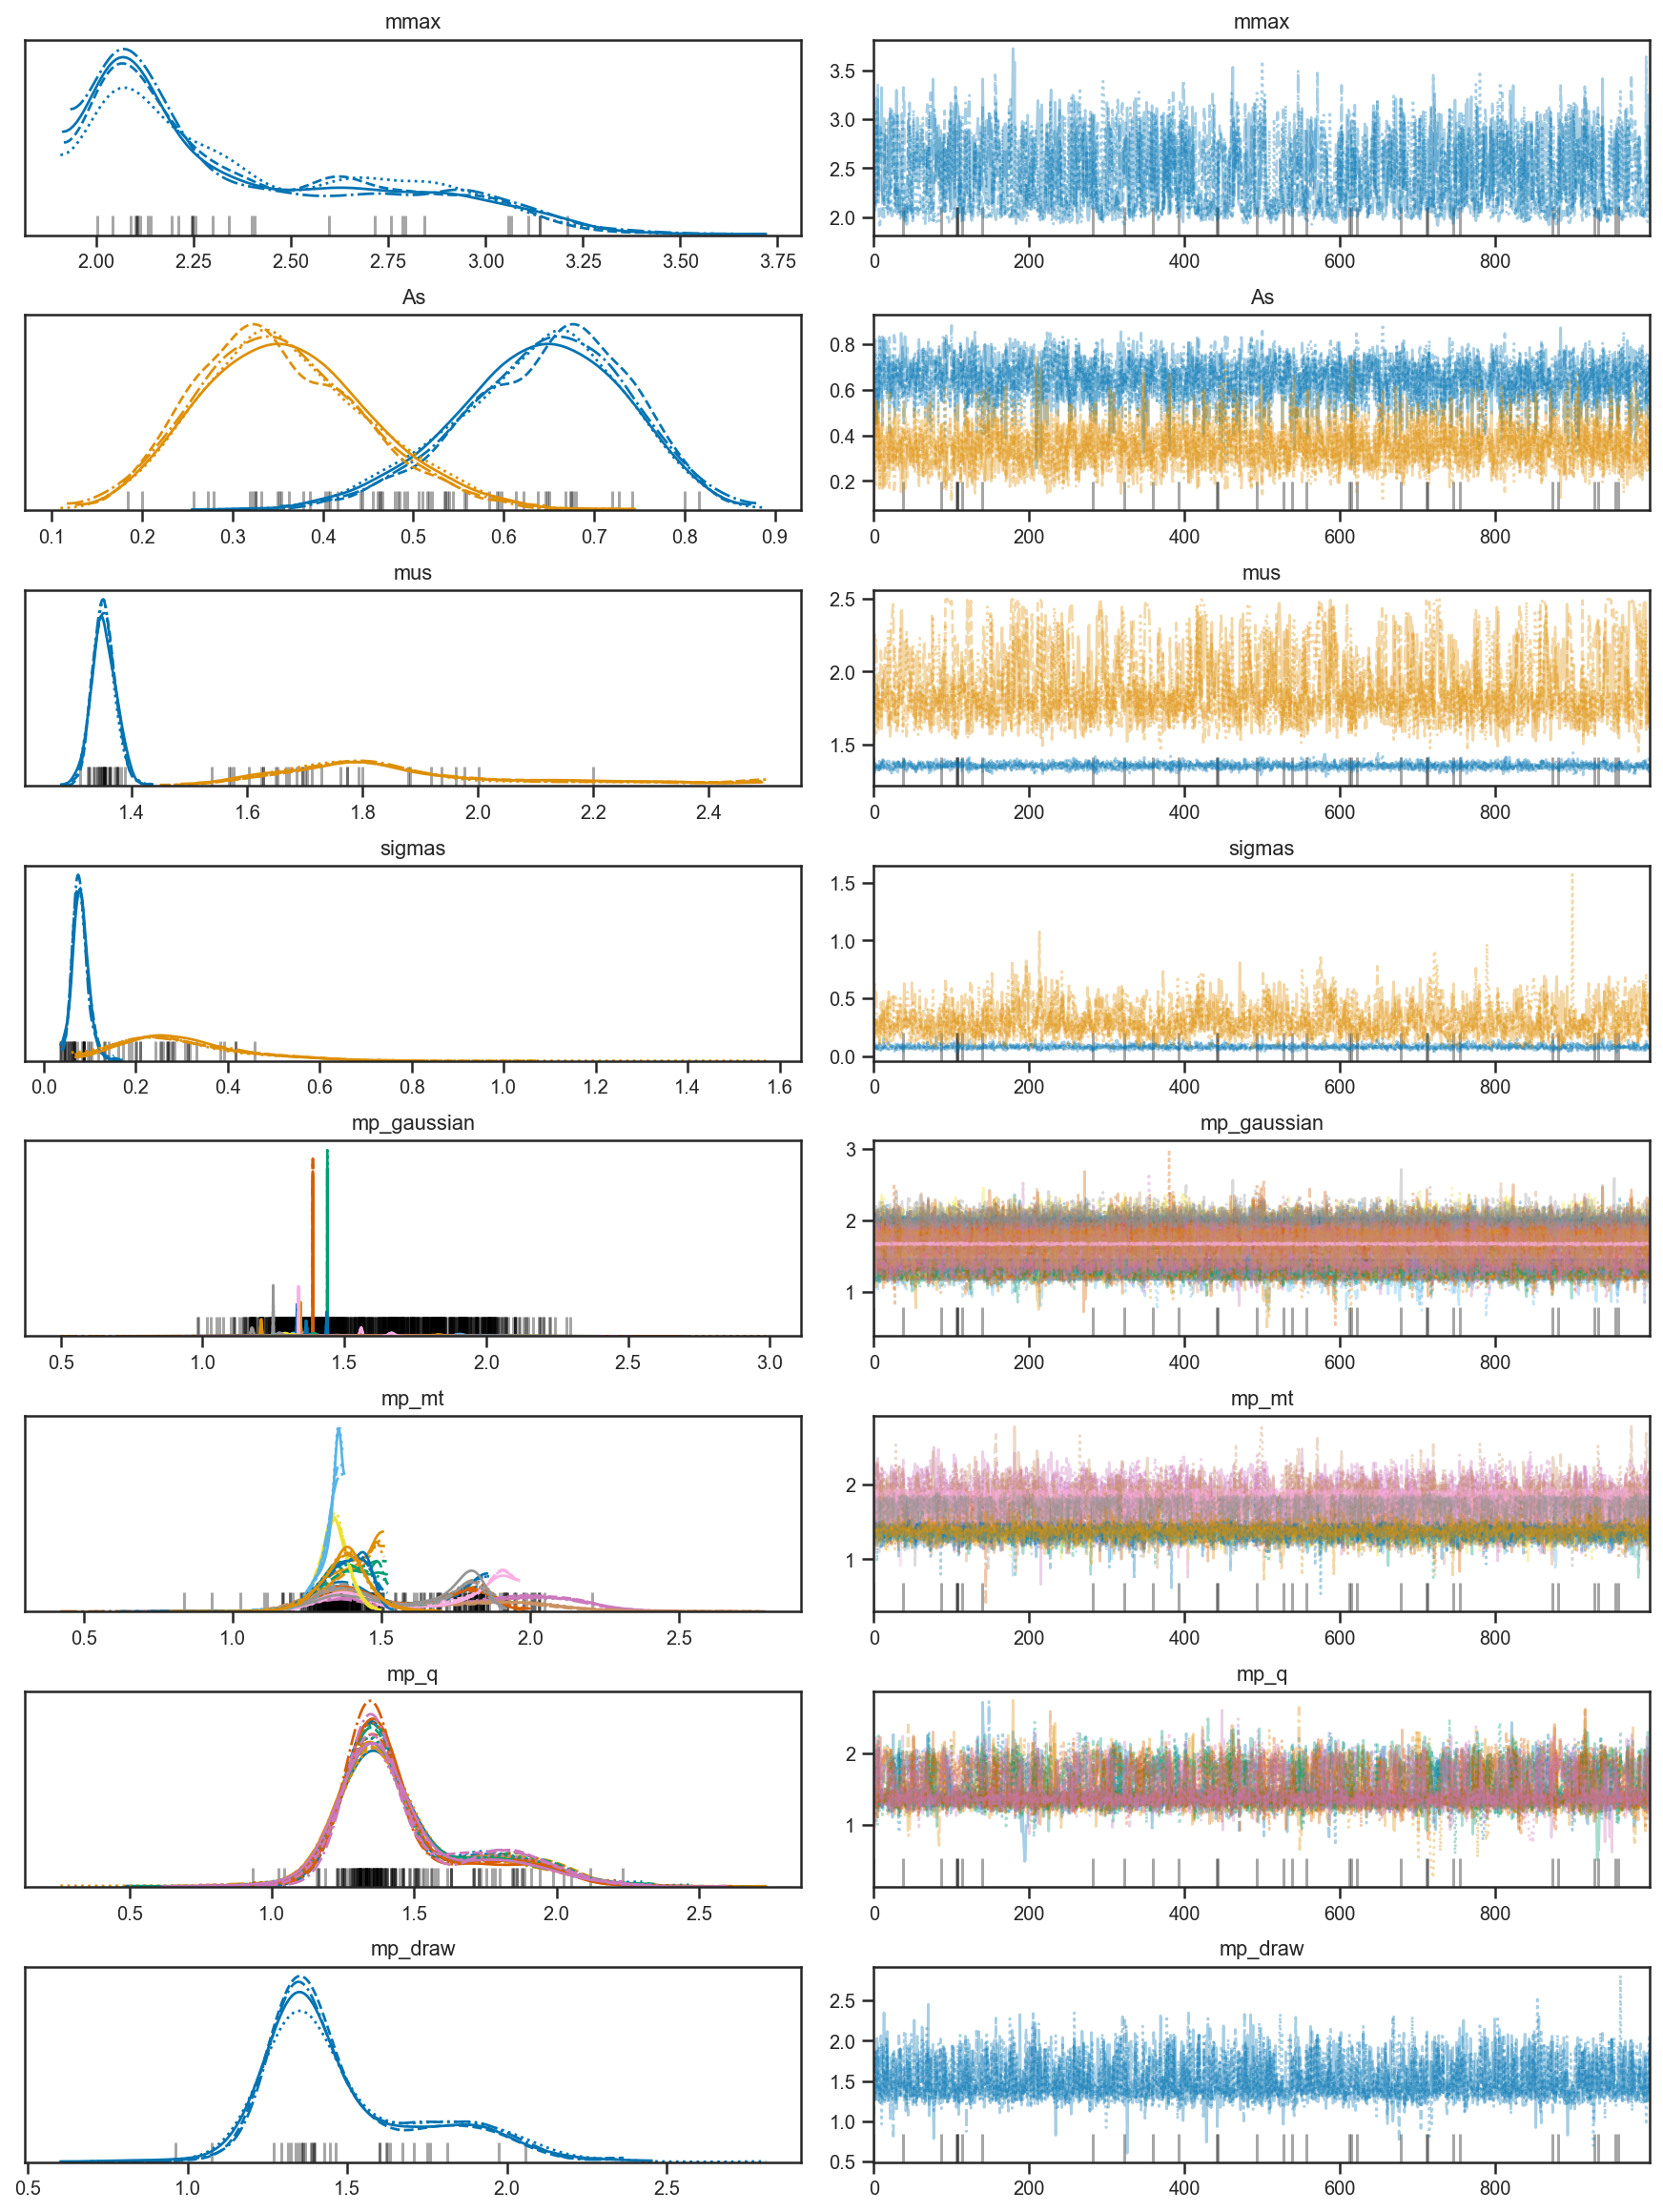

In [5]:
az.plot_trace(fit, compact=True, var_names=['mmax', 'As', 'mus', 'sigmas', 'mp_gaussian', 'mp_mt', 'mp_q', 'mp_draw'])

Here is the posterior on the $m_\mathrm{max}$ parameter.  Because we use a flat prior on (approximately, but to a good approximation) a unit interval, the prior density $p\left( m_\mathrm{max} \right) = 1$.  This means the evidence ratio between this model and the model with $m_\mathrm{max} = 2.9$ is given directly by the prior over the posterior (aka the Savage-Dickey ratio), and appears to be about 2:1 in favor of the variable $m_\mathrm{max}$ (ASB found ~5:1 in favor, so there are apparently some minor differences here).

Text(0, 0.5, '$p\\left( m_\\mathrm{max} \\mid d \\right)$')

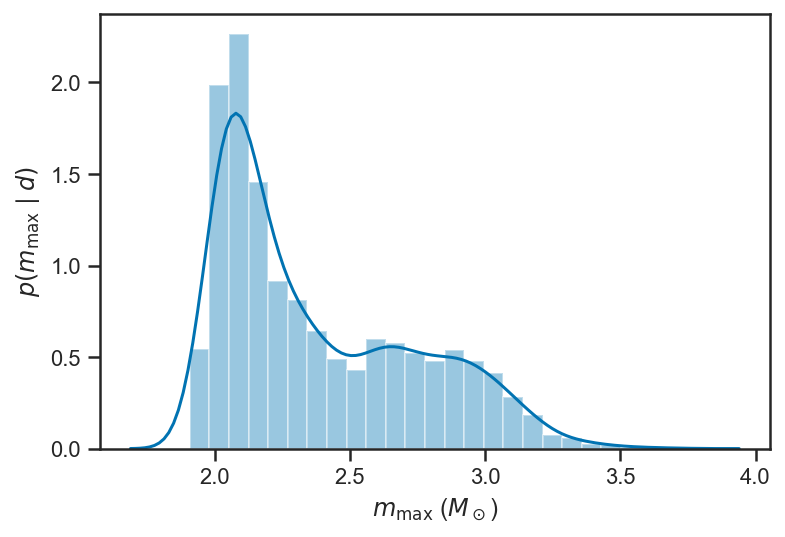

In [12]:
sns.distplot(fit.posterior.mmax.values.flatten())
xlabel(r'$m_\mathrm{max}$ ($M_\odot$)')
ylabel(r'$p\left( m_\mathrm{max} \mid d \right)$')

Here is the marginalized posterior mass distribution for $m_p$:

(1.0, 2.5, 0.0, 3.589714449966334)

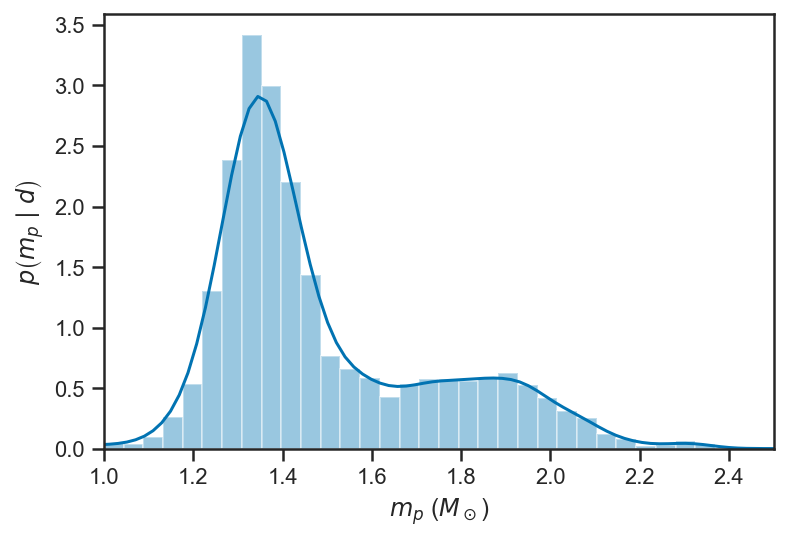

In [13]:
sns.distplot(fit.posterior.mp_draw)
xlabel(r'$m_p$ ($M_\odot$)')
ylabel(r'$p\left(m_p \mid d \right)$')
axis(xmin=1.0, xmax=2.5)

Parameters describing $m_\mathrm{max}$, and $\mu$ and $\sigma$ for the heavier Gaussian component.  There is a dramatic degeneracy in parameter space: either $m_\mathrm{max}$ is small (so there is a sharp cutoff around $2 \, M_\odot$) and then $\mu$ and $\sigma$ can be large, or else both $\mu$ and $\sigma$ are small, and then $m_\mathrm{max}$ can be large).  Essentially, the degeneracy demands that there be very few pulsars with masses above $\sim 2 \, M_\odot$, either due to the presence of a sharp cutoff or due to an intrinsically narrow "heavier" Gaussian mass distribution.

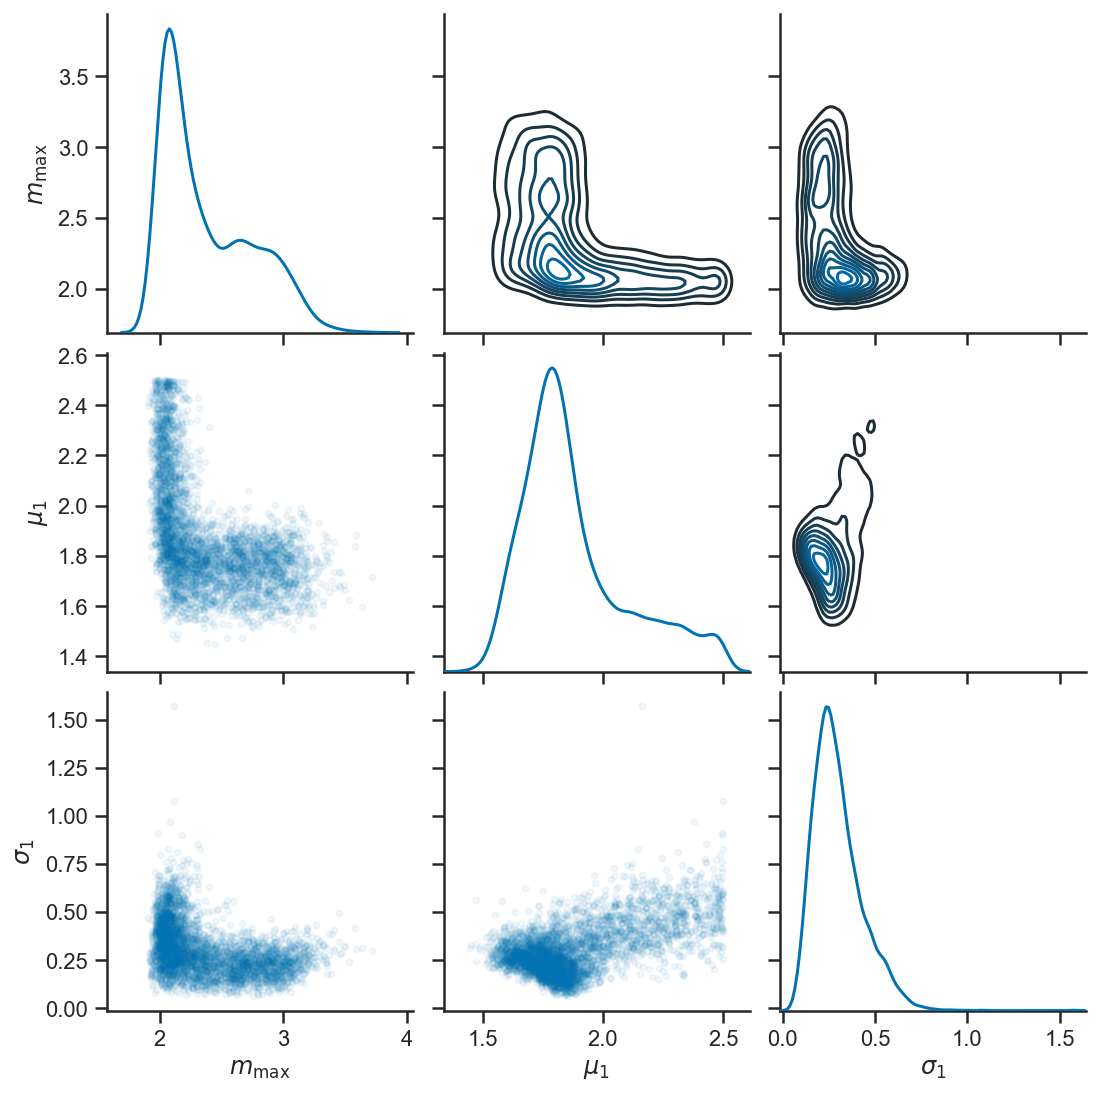

In [18]:
d = pd.DataFrame({
    r'$m_\mathrm{max}$': fit.posterior.mmax.values.flatten(),
    r'$\mu_1$': fit.posterior.mus[:,:,1].values.flatten(),
    r'$\sigma_1$': fit.posterior.sigmas[:,:,1].values.flatten()
})
g = sns.PairGrid(d, diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_upper(sns.kdeplot)
g.map_lower(scatter, marker='.', alpha=0.05)

In [19]:
def plot_one_pdf(ms, mmax, A, mu1, mu2, sigma1, sigma2, norm1, norm2, alpha):
    B = 1-A
    g1 = ss.norm(loc=mu1, scale=sigma1)
    g2 = ss.norm(loc=mu2, scale=sigma2)
        
    ps = A*g1.pdf(ms)/norm1 + B*g2.pdf(ms)/norm2
    ps[ms>mmax] = 0.0

    plot(ms, ps, '-k', alpha=alpha)
    

def plot_dists(fit, Nplot=128):
    ms = linspace(1, 2.5, 128)

    pts = column_stack((fit.posterior.As[:,:,0].values.flatten(),
                        fit.posterior.mus.values.reshape((-1, 2)),
                        fit.posterior.sigmas.values.reshape((-1, 2)))).T
    k = ss.gaussian_kde(pts)
    i, j = unravel_index(argmax(k(pts)), fit.posterior.mmax.shape)
    
    plot_one_pdf(ms, fit.posterior.mmax[i,j].values, 
                 fit.posterior.As[i,j,0].values,
                 fit.posterior.mus[i,j,0].values,
                 fit.posterior.mus[i,j,1].values,
                 fit.posterior.sigmas[i,j,0].values,
                 fit.posterior.sigmas[i,j,1].values,
                 exp(fit.posterior.log_norms[i,j,0].values),
                 exp(fit.posterior.log_norms[i,j,1].values),
                 1.0)
    
    for i in tqdm(range(Nplot)):
        c = np.random.choice(fit.posterior.chain)
        d = np.random.choice(fit.posterior.draw)
        
        A, B = fit.posterior.As[c,d,:].values
        mu1, mu2 = fit.posterior.mus[c,d,:].values
        s1, s2 = fit.posterior.sigmas[c,d,:].values
        mm = fit.posterior.mmax[c,d].values
        n1, n2 = exp(fit.posterior.log_norms[c,d,:].values)
        
        plot_one_pdf(ms, mm, A, mu1, mu2, s1, s2, n1, n2, 3/float(Nplot))
        
    sns.kdeplot(fit.posterior.mp_draw.values.flatten())
    axis(xmin=1, xmax=2.5)
    xlabel(r'$m$ ($M_\odot$)')
    ylabel(r'$p(m)$')

Here we plot some draws from the posterior over mass distributions (light grey lines), the MAP distribution over the marginal distribution for $A$, $\mu$, and $\sigma$ (as in the ASB paper; black line), and the posterior mean mass distribution (blue line).

100%|██████████| 128/128 [00:02<00:00, 56.45it/s]


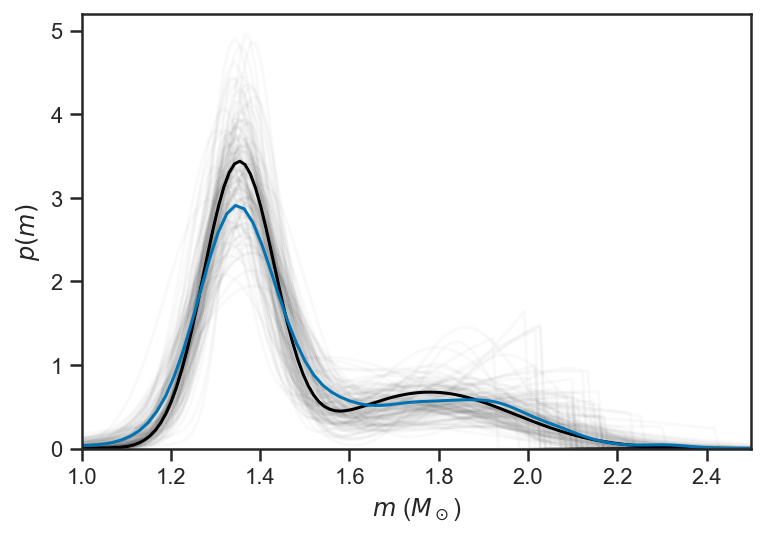

In [20]:
plot_dists(fit)

Here is the distribution we infer for the [Cromartie, et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020NatAs...4...72C/abstract) pulsar mass:

Text(0.5, 1.0, 'Cromartie, et al. (2020): $m_p = 2.034^{+0.100}_{-0.083} \\, M_\\odot$')

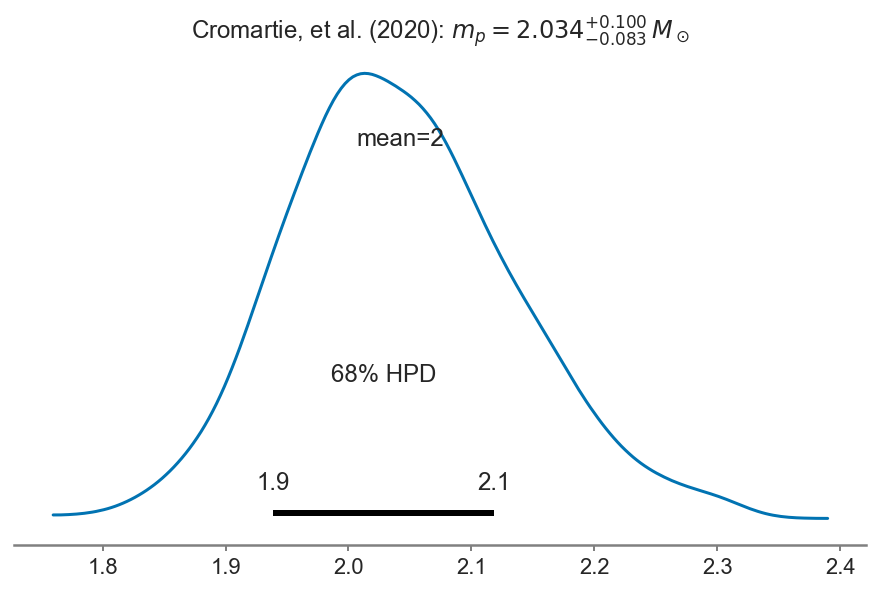

In [13]:
k = fit.posterior.mp_gaussian.shape[2]-1
az.plot_posterior(fit, var_names='mp_gaussian', coords={'mp_gaussian_dim_0': k}, credible_interval=0.68)
m = median(fit.posterior.mp_gaussian[:,:,k])
l = percentile(fit.posterior.mp_gaussian[:,:,k], 16)
h = percentile(fit.posterior.mp_gaussian[:,:,k], 84)
title(r'Cromartie, et al. (2020): $m_p = {:.3f}^{{+{:.3f}}}_{{-{:.3f}}} \, M_\odot$'.format(m, h-m, m-l))

Here is the main plot for the note:

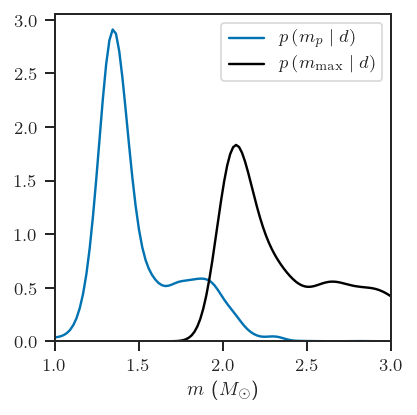

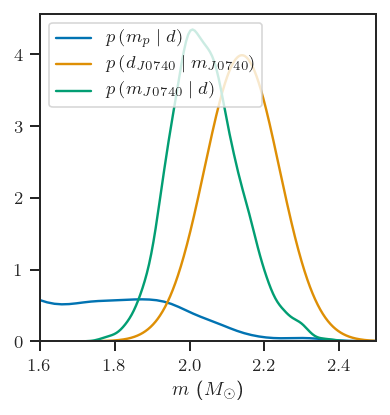

In [31]:
with sns.plotting_context(context='paper'):
    with mpl.rc_context(rc={'figure.figsize': (colwidth/2, colwidth/2), 'text.usetex': True}):
        sns.kdeplot(fit.posterior.mp_draw.values.flatten(), label=r'$p\left( m_p \mid d \right)$')
        sns.kdeplot(fit.posterior.mmax.values.flatten(), label=r'$p\left( m_\mathrm{max} \mid d \right)$', color='k')

        xlabel(r'$m$ ($M_\odot$)')
        legend(loc='best')
        
        axis(xmin=1.0, xmax=3)
        
        savefig('Paper/p-m.pdf')
        
        figure()
        xs = linspace(2.14 - 0.5, 2.14+0.5, 1024)
        sns.kdeplot(fit.posterior.mp_draw.values.flatten(), label=r'$p\left( m_p \mid d \right)$')
        plot(xs, ss.norm(loc=2.14, scale=0.1).pdf(xs), label=r'$p\left( d_{J0740} \mid m_{J0740} \right)$')
        sns.kdeplot(fit.posterior.mp_gaussian[:,:,-1].values.flatten(), label=r'$p\left( m_{J0740} \mid d \right)$')
        axis(xmin=1.6, xmax=2.5)

        xlabel(r'$m$ ($M_\odot$)')
        legend(loc='upper left')
        savefig('Paper/J0740.pdf')